<a href="https://colab.research.google.com/github/0Pedrh0/Automatic_Speech_Processing/blob/main/Projet_3EN_TSI_2025_DNN_TIMIT_Hanni_Benarib_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 3EA : Reconnaissance de phonèmes avec DNN

Ce notebook va vous mettre à disposition une préparation des données et une modélisation très simple. Vous aurez à améliorer cette modélisation pour obtenir de meilleurs performances.

**NOM1** : Hani

**Prénom1** : Badreddine

**Email1** : badrhanib@gmail.com        

**NOM2** : Benarib

**Prénom2** : Ilyes

**Email2** : benarib.ilyes@gmail.com

##Initialisation de l'environnement de TP

Téléchargez les données, puis décompressez-les.
Vous devriez avoir :

`timit_11/`
- `train_11.npy`: données acoustiques<br>
- `train_label_11.npy`: étiquettes associées<br>

Si dessous le code pour télécharger les données et effectuer la liaison avec le noteboook

In [33]:
# Liaison avec les données
#!git clone https://gitlab.com/jeromefarinas/reco-parole-dnn.git
#!cd reco-parole-dnn && git lfs pull

In [34]:
#unzip reco-parole-dnn/timit_11.zip
#!tree timit_11/

In [35]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')

print('Taille des données : {}'.format(train.shape))

Loading data ...
Taille des données : (1229932, 429)


## Création de la base de données

In [36]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


Diviser les données étiquetées en un ensemble d'entraînement et un ensemble de validation, vous pouvez modifier la variable `VAL_RATIO` pour changer le ratio des données de validation.

# La dimension d'arrivée (429) est issue de 11 fenêtres de 39 paramètres issus de MFCC (12 MFCC + E + Delta + Delta Delta)

In [37]:
VAL_RATIO = 0.15

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, test_x, test_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Taille de l\'ensemble d\'apprentissage : {}'.format(train_x.shape))
print('Taille de l\'ensemble de validation: {}'.format(test_x.shape))

Taille de l'ensemble d'apprentissage : (1045442, 429)
Taille de l'ensemble de validation: (184490, 429)


***Affichez un exemple de donnée de l'ensemble d'apprentissage que vous allez traiter. La matrice est centrée sur le milieu du phonème à modéliser.***

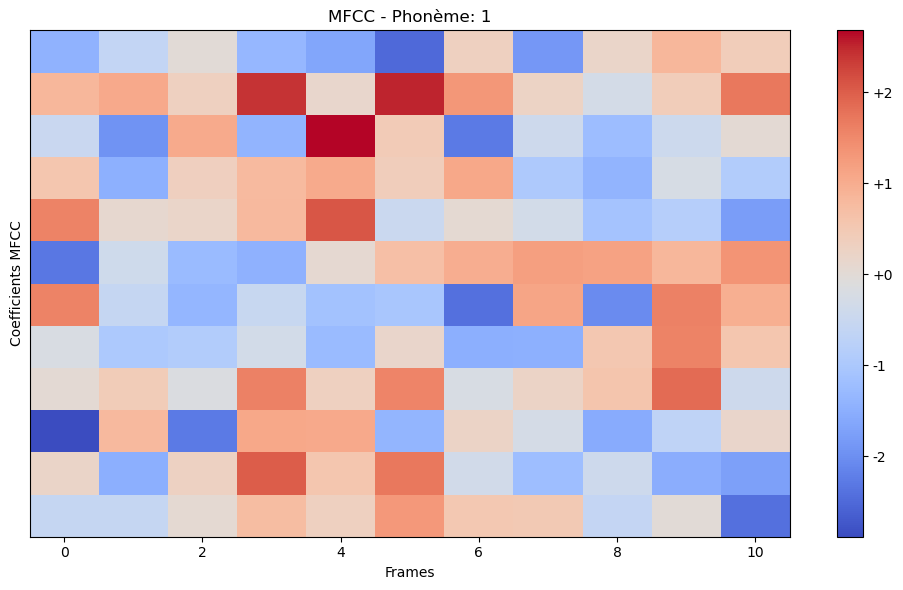

In [38]:
from matplotlib import pyplot as plt
import librosa

# ------------------------- Affichage d'un exemple d'un ensemble de donnée de l'ensemble d'apprentissage --------------------------------------------

# Selection de l'exemple à traiter
k = 15

Exemple, Label = train_x[k], train_y[k]

# Reshape (39 features x 11 frames)
donnes = np.reshape(Exemple, (39, 11))

# Extraction des 12 premiers coefficients MFCC
mfccs = donnes[:12, :]

# Affichage de la matrice MFCC
plt.figure(figsize=(10, 6))
img = librosa.display.specshow(mfccs, x_axis='frames')
plt.colorbar(img, format='%+2.0f')
plt.title(f'MFCC - Phonème: {Label}')
plt.ylabel('Coefficients MFCC')
plt.tight_layout()
plt.show()

***Quel est le label associé ? (code + signification)***

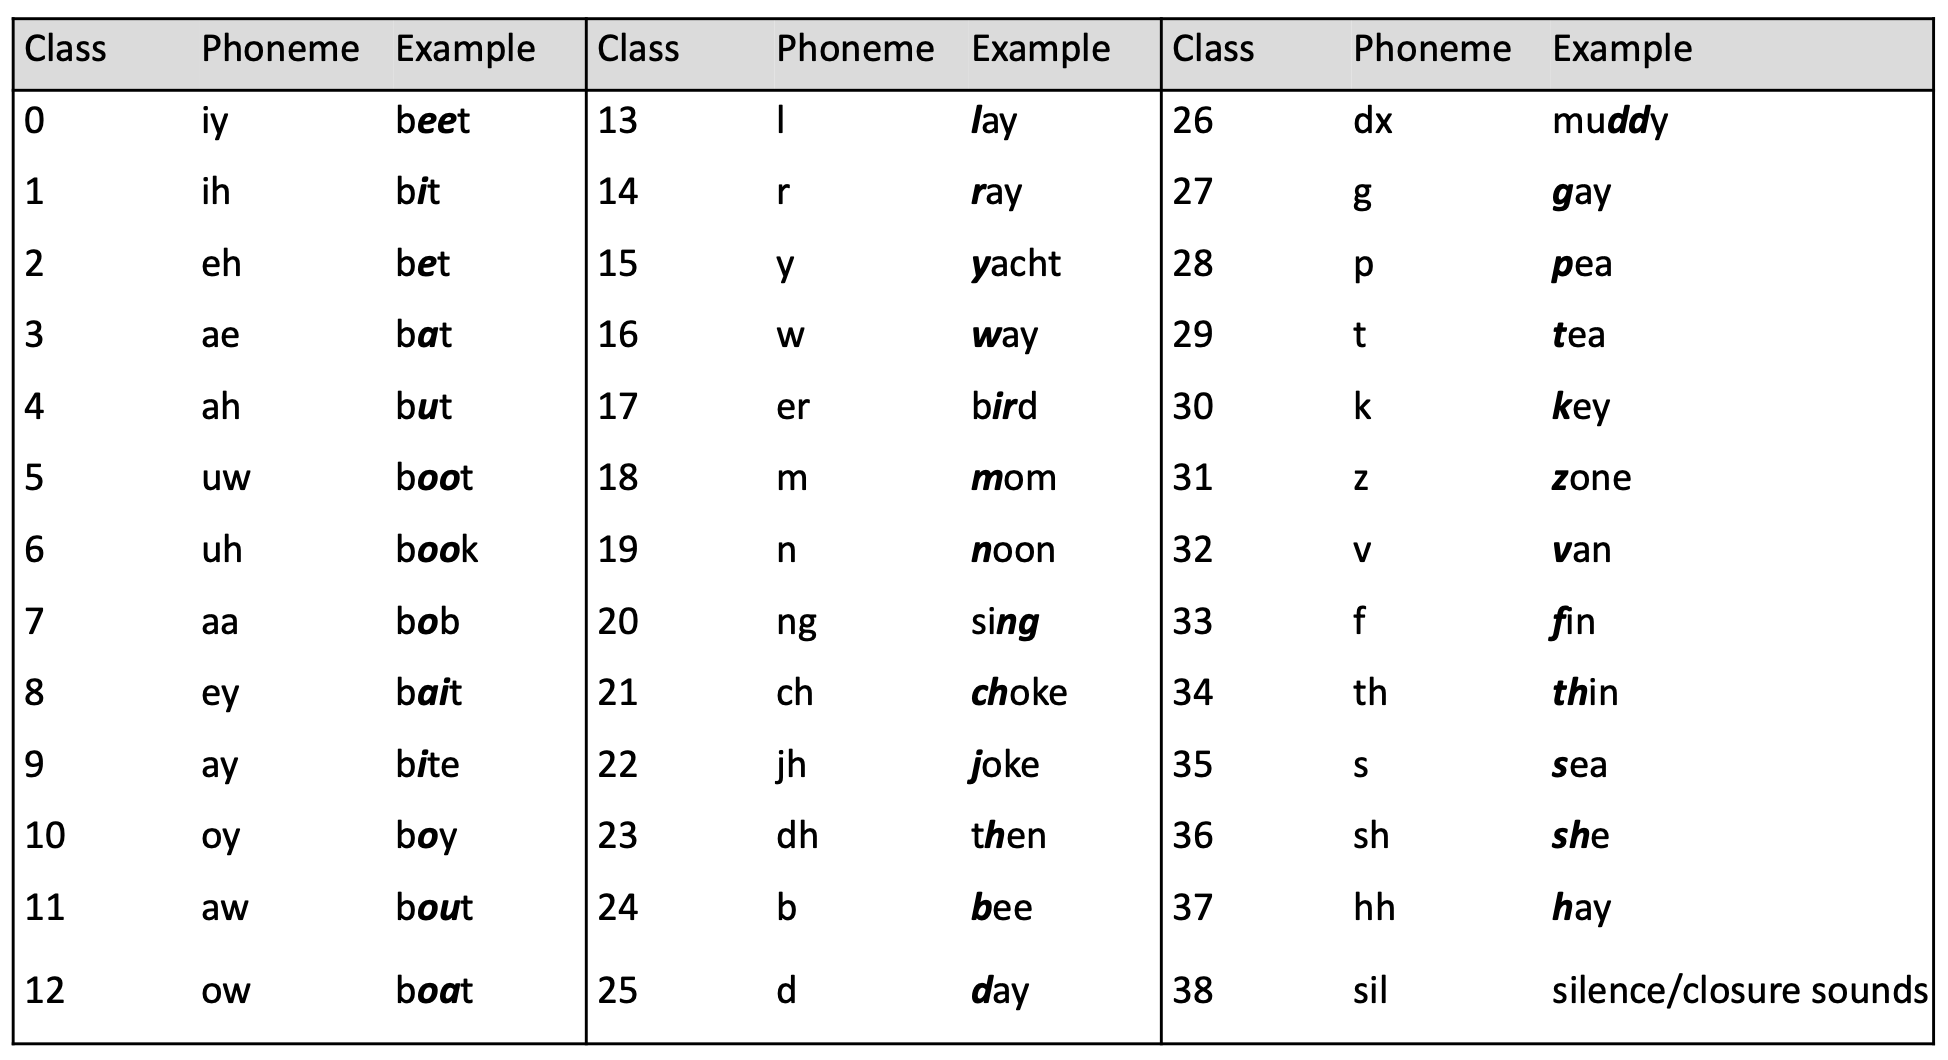

In [39]:
print(f" Le label associé à l'exemple est : {Label}\n","Il correspond au phonème [ih]")

 Le label associé à l'exemple est : 1
 Il correspond au phonème [ih]


Créez un chargeur de données à partir du jeu de données, n'hésitez pas à modifier la variable `BATCH_SIZE` ici.

In [40]:
BATCH_SIZE = 2056

from torch.utils.data import DataLoader 

train_set = TIMITDataset(train_x, train_y)
test_set = TIMITDataset(test_x, test_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


Nettoyer les variables inutiles pour économiser de la mémoire.
<br>

**notes: si vous avez besoin d'utiliser ces variables plus tard, vous pouvez supprimer ce bloc ou nettoyer les variables inutiles plus tard<br>la taille des données est assez importante, il faut donc faire attention à l'utilisation de la mémoire dans la colab...**

In [41]:
import gc

# del train, train_label, train_x, train_y, test_x, test_y
# gc.collect()

## Création d'un modèle

In [42]:
import torch
import torch.nn as nn

class Classifier_MLP(nn.Module):
    def __init__(self, num_classes = 39):
        super(Classifier_MLP, self).__init__()
        self.layers = nn.Sequential(
           nn.Linear(11 * 39, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
          )



    def forward(self, x):
        x = self.layers(x)

        return x

## Apprentissage

In [43]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fixer le générateur aléatoire pour la reproductibilité.

In [44]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Paramètres d'apprentissage

In [45]:
# fix random seed for reproducibility
same_seeds(0)

# get device
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 50              # number of training epoch
learning_rate = 0.001     # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier_MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [46]:
# start training
best_acc = 0.0
train_loss_tab, val_loss_tab = [], []
train_acc_tab, val_acc_tab = [], []
train_set_len = len(train_loader)
val_set_len = len(val_loader)

for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    train_loss_tab.append(train_loss / len(train_loader))
    train_acc_tab.append(train_acc/len(train_set))
    # validation
    if len(test_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1)

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()
            val_loss_tab.append(val_loss / len(val_loader))
            val_acc_tab.append(val_acc/len(test_set))

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(test_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(test_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(test_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

[001/050] Train Acc: 0.554467 Loss: 1.491212 | Val Acc: 0.670454 loss: 1.050036
saving model with acc 0.670
[002/050] Train Acc: 0.622826 Loss: 1.225332 | Val Acc: 0.692872 loss: 0.967036
saving model with acc 0.693
[003/050] Train Acc: 0.644672 Loss: 1.145559 | Val Acc: 0.708033 loss: 0.913783
saving model with acc 0.708
[004/050] Train Acc: 0.658201 Loss: 1.097276 | Val Acc: 0.714478 loss: 0.887870
saving model with acc 0.714
[005/050] Train Acc: 0.668643 Loss: 1.061449 | Val Acc: 0.719871 loss: 0.865332
saving model with acc 0.720
[006/050] Train Acc: 0.675677 Loss: 1.034036 | Val Acc: 0.727731 loss: 0.840637
saving model with acc 0.728
[007/050] Train Acc: 0.681372 Loss: 1.012545 | Val Acc: 0.728468 loss: 0.836210
saving model with acc 0.728
[008/050] Train Acc: 0.686445 Loss: 0.994354 | Val Acc: 0.733655 loss: 0.821064
saving model with acc 0.734
[009/050] Train Acc: 0.690874 Loss: 0.978050 | Val Acc: 0.735834 loss: 0.810525
saving model with acc 0.736
[010/050] Train Acc: 0.69416

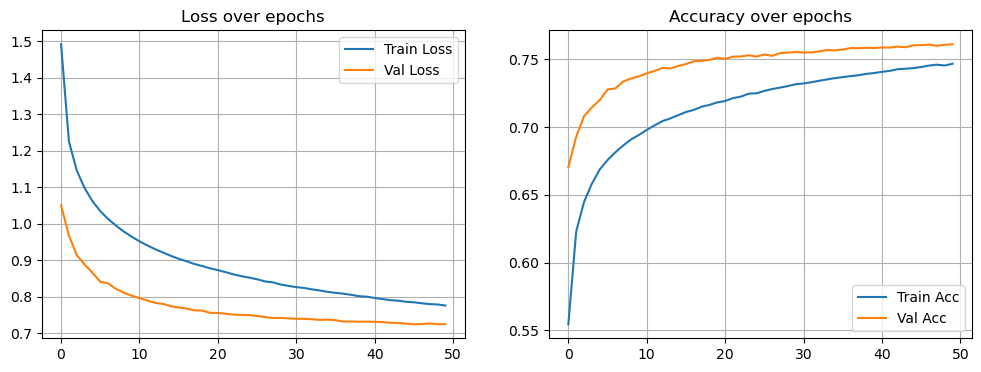

In [47]:
# Plot de la focntion de loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_tab, label='Train Loss')
plt.plot(val_loss_tab, label='Val Loss')
plt.legend()
plt.grid()
plt.title('Loss over epochs')

# Plot de la précision
plt.subplot(1, 2, 2)
plt.plot(train_acc_tab, label='Train Acc')
plt.plot(val_acc_tab, label='Val Acc')
plt.legend()
plt.grid()
plt.title('Accuracy over epochs')

plt.show()

## Adaptation du format de la base de données

In [ ]:
# Reshape des données
n = train_x.shape[0]
m = test_x.shape[0]
hauteur = 39
largeur = 11
#Normalisation pour réduire les problèmes de Loss élevée et accuracy faible depuis le début.
def normalize(data):
    mean = data.mean(axis=(1, 2, 3), keepdims=True)
    std = data.std(axis=(1, 2, 3), keepdims=True)
    return (data - mean) / (std + 1e-8)

reshape_train_set = normalize(torch.tensor(reshape_train_set))
reshape_test_set = normalize(torch.tensor(reshape_test_set))
# Reshape direct sans boucle
reshape_train_set = train_x.reshape(n, 39, 11).reshape(n, 1, 39, 11)
reshape_test_set = test_x.reshape(m, 39, 11).reshape(m, 1, 39, 11)

# Vérification des formes
print("Forme de reshape_train_set :", reshape_train_set.shape)
print("Forme de reshape_test_set :", reshape_test_set.shape)

# Création des datasets
BATCH_SIZE = 64
train_set = TIMITDataset(reshape_train_set, train_y)
test_set = TIMITDataset(reshape_test_set, test_y)

# Création des dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Forme de reshape_train_set : (1045442, 1, 39, 11)
Forme de reshape_test_set : (184490, 1, 39, 11)


## Création d'un modèle à base de CNN

In [ ]:
# On tente l'implémentation d'une autre architecture à base de CNN pour reconnaitre les motifs dans les données

import torch.nn.functional as F

class Classifier_CNN(nn.Module):
    def __init__(self, num_classes=39):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Ajouter Batch Normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Couches denses réduites pour éviter trop de paramètres
        self.fc1 = nn.Linear(64*19*5, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)#Normalisation pour réduire les problèmes de Loss élevée et accuracy faible depuis le début.
def normalize(data):
    mean = data.mean(axis=(1, 2, 3), keepdims=True)
    std = data.std(axis=(1, 2, 3), keepdims=True)
    return (data - mean) / (std + 1e-8)

reshape_train_set = normalize(torch.tensor(reshape_train_set))
reshape_test_set = normalize(torch.tensor(reshape_test_set))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [ ]:
# fix random seed for reproducibility
same_seeds(0)

# get device
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 50               # number of training epoch
learning_rate = 0.0001     # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning#Normalisation pour réduire les problèmes de Loss élevée et accuracy faible depuis le début.
def normalize(data):
    mean = data.mean(axis=(1, 2, 3), keepdims=True)
    std = data.std(axis=(1, 2, 3), keepdims=True)
    return (data - mean) / (std + 1e-8)

reshape_train_set = normalize(torch.tensor(reshape_train_set))
reshape_test_set = normalize(torch.tensor(reshape_test_set))_rate)

# Vérification des formes
print("Forme de reshape_train_set :", reshape_train_set.shape)
print("Forme de reshape_test_set :", reshape_test_set.shape)

DEVICE: cuda
Forme de reshape_train_set : (1045442, 1, 39, 11)
Forme de reshape_test_set : (184490, 1, 39, 11)


In [51]:
# Initialisation des métriques
best_acc = 0.0
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

# Boucle d'entraînement
for epoch in range(num_epoch):
    # --- Phase d'entraînement ---
    model.train()
    running_train_acc = 0.0
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass et optimisation
        loss.backward()
        optimizer.step()

        # Calcul des métriques
        _, train_pred = torch.max(outputs, 1)
        running_train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        running_train_loss += loss.item()

    # Normalisation des métriques d'entraînement (par époque)
    epoch_train_acc = running_train_acc / len(train_loader.dataset)
    epoch_train_loss = running_train_loss / len(train_loader)
    train_acc_history.append(epoch_train_acc)
    train_loss_history.append(epoch_train_loss)

    # --- Phase de validation ---
    if len(val_loader.dataset) > 0:
        model.eval()
        running_val_acc = 0.0
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calcul des métriques de validation
                _, val_pred = torch.max(outputs, 1)
                running_val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                running_val_loss += loss.item()

        # Normalisation des métriques de validation (par époque)
        epoch_val_acc = running_val_acc / len(val_loader.dataset)
        epoch_val_loss = running_val_loss / len(val_loader)
        val_acc_history.append(epoch_val_acc)
        val_loss_history.append(epoch_val_loss)

        # Affichage des métriques
        print(f'Epoch [{epoch + 1}/{num_epoch}] | '
              f'Train Acc: {epoch_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f} | '
              f'Val Acc: {epoch_val_acc:.4f} | Val Loss: {epoch_val_loss:.4f}')

        # Sauvegarde du meilleur modèle
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), model_path)
            print(f'New best model saved with val_acc = {best_acc:.4f}')
    else:
        # Cas sans validation (entraînement seulement)
        print(f'Epoch [{epoch + 1}/{num_epoch}] | '
              f'Train Acc: {epoch_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f}')

# Sauvegarde finale (si pas de validation)
if len(val_loader.dataset) == 0:
    torch.save(model.state_dict(), model_path)
    print('Final model saved (no validation set)')


Epoch [1/50] | Train Acc: 0.5635 | Train Loss: 1.4496 | Val Acc: 0.6702 | Val Loss: 1.0597
New best model saved with val_acc = 0.6702
Epoch [2/50] | Train Acc: 0.6175 | Train Loss: 1.2339 | Val Acc: 0.6859 | Val Loss: 0.9900
New best model saved with val_acc = 0.6859
Epoch [3/50] | Train Acc: 0.6329 | Train Loss: 1.1738 | Val Acc: 0.6900 | Val Loss: 0.9773
New best model saved with val_acc = 0.6900
Epoch [4/50] | Train Acc: 0.6430 | Train Loss: 1.1360 | Val Acc: 0.7001 | Val Loss: 0.9451
New best model saved with val_acc = 0.7001
Epoch [5/50] | Train Acc: 0.6502 | Train Loss: 1.1092 | Val Acc: 0.7016 | Val Loss: 0.9302
New best model saved with val_acc = 0.7016
Epoch [6/50] | Train Acc: 0.6554 | Train Loss: 1.0883 | Val Acc: 0.7043 | Val Loss: 0.9162
New best model saved with val_acc = 0.7043
Epoch [7/50] | Train Acc: 0.6595 | Train Loss: 1.0722 | Val Acc: 0.7048 | Val Loss: 0.9124
New best model saved with val_acc = 0.7048
Epoch [8/50] | Train Acc: 0.6628 | Train Loss: 1.0573 | Val Ac

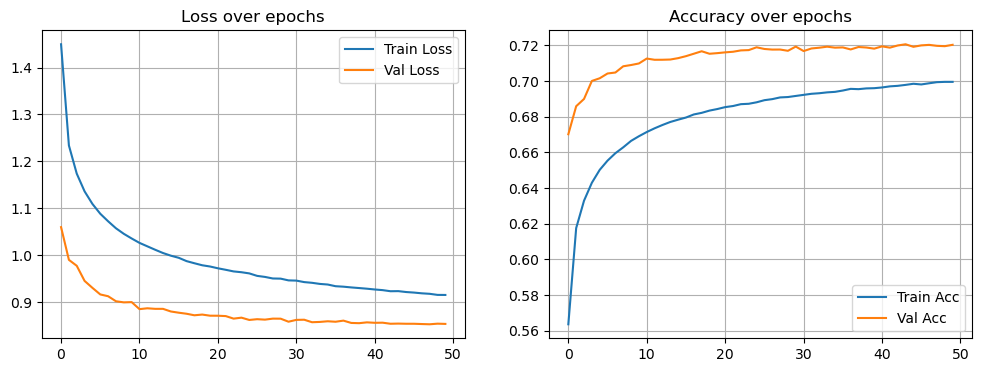

In [ ]:
# Plot de la focntion de loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend()
plt.grid()
plt.title('Loss over epochs')

# Plot de la précision
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.legend()
plt.grid()
plt.title('Accuracy over epochs')

plt.show()

...

## Créartion d'un modèle à base de CNN résiduel

In [56]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class ResidualCNN(nn.Module):
    def __init__(self, num_classes=39):
        super(ResidualCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(1, 7), padding=(0, 3))  # Noyau temporel plus large et plus de filtres
        self.bn1 = nn.BatchNorm2d(128)
        self.res_block1 = ResidualBlock(128, 256, stride=(1, 2))
        self.res_block2 = ResidualBlock(256, 512, stride=(1, 2))
        self.res_block3 = ResidualBlock(512, 512, stride=(1, 2))  
        self.dropout = nn.Dropout(0.3)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res_block1(x)
        x = self.dropout(x)
        x = self.res_block2(x)
        x = self.dropout(x)
        x = self.res_block3(x)
        x = self.dropout(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [60]:
# Fix random seed for reproducibility
same_seeds(0)

# Training parameters
num_epoch = 10              # Augmenté pour permettre une convergence plus longue
learning_rate = 0.0001       # Learning rate réduit pour stabiliser l'entraînement
weight_decay = 1e-4           # Régularisation L2 pour éviter l'overfitting

# Path where checkpoint is saved
model_path = './model.ckpt'

# Création du model et utilisation d'un schduler pour résoudre les problèmes de réglages su rle learning rate
model = ResidualCNN(num_classes=39).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [61]:
# Initialisation des métriques
best_acc = 0.0
train_loss_tab = []
val_loss_tab = []
train_acc_tab = []
val_acc_tab = []

# Boucle d'entraînement
for epoch in range(num_epoch):
    # --- Phase d'entraînement ---
    model.train()
    train_acc = 0.0
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1)

        batch_loss.backward()
        optimizer.step()

        # Accumulation des métriques
        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # Normalisation des métriques d'entraînement
    train_acc = train_acc / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader)

    # Stockage des métriques
    train_loss_tab.append(train_loss)
    train_acc_tab.append(train_acc)

    # --- Phase de validation ---
    if len(val_loader.dataset) > 0:
        model.eval()
        val_acc = 0.0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1)

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += batch_loss.item()
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
                scheduler.step(val_loss)  # À appeler après le calcul de val_loss


        # Normalisation des métriques de validation
        val_acc = val_acc / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader)

        # Stockage des métriques
        val_loss_tab.append(val_loss)
        val_acc_tab.append(val_acc)

        # Affichage des métriques
        print(f'[{epoch + 1}/{num_epoch}] Train Acc: {train_acc:.4f} Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} Loss: {val_loss:.4f}')

        # Sauvegarde du modèle si amélioration
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f'Saving model with acc {best_acc:.4f}')
    else:
        print(f'[{epoch + 1}/{num_epoch}] Train Acc: {train_acc:.4f} Loss: {train_loss:.4f}')

# Sauvegarde finale si pas de validation
if len(val_loader.dataset) == 0:
    torch.save(model.state_dict(), model_path)
    print('Saving model at last epoch')


[1/10] Train Acc: 0.6197 Loss: 1.2224 | Val Acc: 0.6821 Loss: 0.9964
Saving model with acc 0.6821
[2/10] Train Acc: 0.7061 Loss: 0.9074 | Val Acc: 0.7132 Loss: 0.8971
Saving model with acc 0.7132
[3/10] Train Acc: 0.7391 Loss: 0.7914 | Val Acc: 0.7182 Loss: 0.8910
Saving model with acc 0.7182
[4/10] Train Acc: 0.7621 Loss: 0.7120 | Val Acc: 0.7256 Loss: 0.8768
Saving model with acc 0.7256
[5/10] Train Acc: 0.7812 Loss: 0.6492 | Val Acc: 0.7294 Loss: 0.8820
Saving model with acc 0.7294
[6/10] Train Acc: 0.7967 Loss: 0.5976 | Val Acc: 0.7247 Loss: 0.9226
[7/10] Train Acc: 0.8094 Loss: 0.5558 | Val Acc: 0.7242 Loss: 0.9466
[8/10] Train Acc: 0.8207 Loss: 0.5187 | Val Acc: 0.7224 Loss: 0.9857
[9/10] Train Acc: 0.8304 Loss: 0.4871 | Val Acc: 0.7252 Loss: 0.9877
[10/10] Train Acc: 0.8395 Loss: 0.4599 | Val Acc: 0.7247 Loss: 1.0338


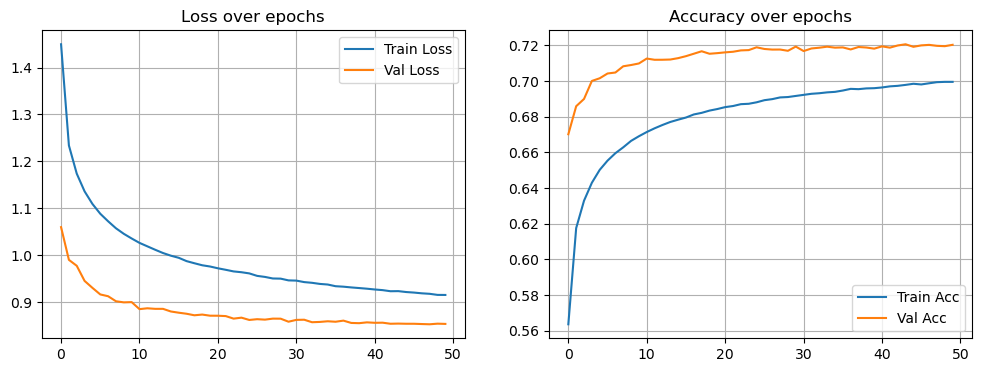

In [62]:
# Plot de la focntion de loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend()
plt.grid()
plt.title('Loss over epochs')

# Plot de la précision
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.legend()
plt.grid()
plt.title('Accuracy over epochs')

plt.show()